In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Conv1D,GlobalMaxPooling1D,Input,Lambda
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras import backend as K
plt.style.use('ggplot')
%matplotlib inline
import tensorflow_hub as hub


Using TensorFlow backend.


In [2]:
# tf.compat.v1.disable_eager_execution()

In [17]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')

### Data Prep

In [18]:
filepath_dict = {'yelp': "datasets/sentiment_labelled_sentences/yelp_labelled.txt",
                 'amazon': "datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt",
                 'imdb': "datasets/sentiment_labelled_sentences/imdb_labelled.txt"
                 }
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
   # Add another column filled with the source name
    df['source'] = source
    df_list.append(df)  
    df = pd.concat(df_list)

In [19]:
df['sentence']

0                               Wow... Loved this place.
1                                     Crust is not good.
2              Not tasty and the texture was just nasty.
3      Stopped by during the late May bank holiday of...
4      The selection on the menu was great and so wer...
                             ...                        
743    I just got bored watching Jessice Lange take h...
744    Unfortunately, any virtue in this film's produ...
745                     In a word, it is embarrassing.  
746                                 Exceptionally bad!  
747    All in all its an insult to one's intelligence...
Name: sentence, Length: 2748, dtype: object

In [20]:
# df = df[df['source']== "yelp"]
sentences = df['sentence'].values
y = df['label'].values
# tokenizer = Tokenizer(lower=True,num_words=10000)
# tokenizer.fit_on_texts(sentences)
sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,
                                                test_size=0.15,
                                                random_state=1000)

print(Counter(y_train),Counter(y_test))
tokenizer = Tokenizer(lower=True)
#                       ,num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

maxlen = 100
vocab_size = len(tokenizer.word_index) + 1

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# y_train = to_categorical(num_classes=2,y=y_train)
# y_test = to_categorical(num_classes=2,y=y_test)




Counter({1: 1173, 0: 1162}) Counter({1: 213, 0: 200})


In [21]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# module_url = "https://tfhub.dev/google/elmo/3"
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

In [30]:

def createLSTM():
    model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
    hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=False)
    model = tf.keras.Sequential()
    model.add(hub_layer)
#     model.add(LSTM(192,)))
#     model.add(tf.keras.layers.Dense(16, activation='relu'))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


### LSTM

In [31]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
# def ELMoEmbedding(x):
#     return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]


#     model.add(Lambda(ELMoEmbedding, output_shape=(1024, )))
#     model.add(Input(shape=(1,), dtype="string"))
#     model.add(Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
#     model.add(LSTM(192))



# def createLSTM():
# #     hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", dtype=tf.string,input_shape=[],output_shape=[20],trainable=True)
#     model=Sequential()
#     model.add(hub_layer)

#     model.add(Dense(100,activation='relu'))
#     model.add(Dense(1,activation='sigmoid'))
#     return model

In [32]:
model= createLSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# history = model.fit(sentences_train,y_train,batch_size=16,epochs=10,validation_data=(sentences_test, y_test),verbose=1)
model.fit(sentences_train,y_train,batch_size=16,epochs=10,verbose=1)
# plot_history(history)

ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 20]

In [237]:
model.evaluate(X_test,y_test)

413/413 [==============================] - 0s 138us/step


[0.8174563792080913,
 0.7941888570785522,
 0.7947531938552856,
 0.7949270606040955,
 0.7948084473609924]

# CNN

In [258]:
# def f1score(y_true,y_pred):

#     # Count positive samples.
#     c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

#     # If there are no true samples, fix the F1 score at 0.
#     if c3 == 0:
#         return 0

#     # How many selected items are relevant?
#     precision = c1 / c2

#     # How many relevant items are selected?
#     recall = c1 / c3

#     # Calculate f1_score
#     f1_score = 2 * (precision * recall) / (precision + recall)
#     return f1_score


def createCNN(vocab_size,embedding_dim,maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 100, 100)          488400    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 96, 64)            32064     
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_132 (Dense)            (None, 2)                 22        
Total params: 521,136
Trainable params: 521,136
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2335 samples, validate on 413 samples
Epoch 1/10
2335/2335 [==============================] - 1s 590us/step - loss: 0.6887 - acc: 0.5285 - f1_m: 0.4832 - precision_m: 0.5431 - recall_m: 0.4433 - val_loss: 0.6740 - val_acc: 0.6247 - val_f1_m: 0.5377 - val_precision_m: 0.6975 - val_recall_m: 0.4386
Epoch 2/10
2335/2335 [==============================] - 1s 494us/step - loss: 0.5967 - acc: 0.6743 - f1_m: 0.5930 - precision_m: 0.7829 - recall_m: 0.4824 - val_loss: 0.5034 - val_acc: 0.8196 - val_f1_m: 0.7999 - val_precision_m: 0.8963 - val_recall_m: 0.7240
Epoch 3/10
2335/2335 [==============================] - 1s 487us/step - loss: 0.2892 - acc: 0.9208 - f1_m: 0.9198 - precision_m: 0.9292 - recall_m: 0.9114 - val_loss: 0.3683 - val_acc: 0.8317 - val_f1_m: 0.8320 - val_precision_m: 0.8311 - val_recall_m: 0.8331
Epoch 4/10
2335/2335 [==============================] - 1s 491us/step - loss: 0.1129 - acc: 0.9687 - f1_m: 0.9688 - precision_m: 0.9689 - recall_m: 0.9688 - val_loss: 0.3866

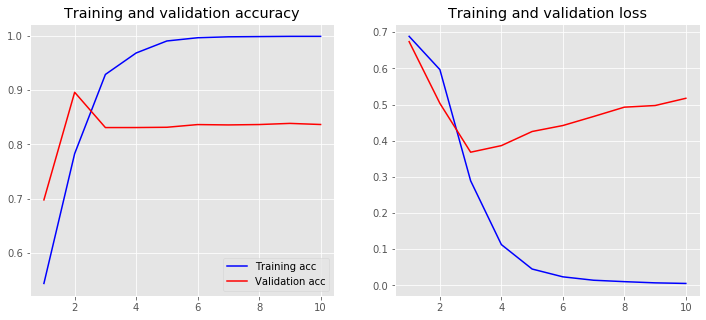

In [259]:
cnn_model=createCNN(vocab_size,100,maxlen)
cnn_model.summary()
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1_m,precision_m,recall_m])
history = cnn_model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_test, y_test),verbose=1)
plot_history(history)

In [218]:
cnn_model.evaluate(X_test,y_test)


413/413 [==============================] - 0s 53us/step


[0.7902967612333506,
 0.7905569076538086,
 0.789658784866333,
 0.7926916480064392,
 0.7867208123207092]